In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 200)

import joblib
import gc

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from fast_ml.model_development import train_valid_test_split
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import preprocessing


import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%time
# reading the datasets
data = pd.read_csv('data1.csv',sep=';', encoding='latin-1')
data.columns= data.columns.str.lower()
data['address1'] = data['address1'].str.upper()

data2 = pd.read_parquet('Segmenten_kenmerken_all_cols.parquet.gzip')
data2 = data2[['matchkey','whize_segment', 'whize_subsegment', 'gezinsinkomen', 'werksituatie',  'hh_car', 'huishoudgrootte']]

Wall time: 57.9 s


### Merging datasets

In [ ]:
data2 = data2[~data2['address1'].str.contains('POSTBUS')] # if the adress is a postbus this row should be removed from the dataset (approx 130 rows)


newdf= pd.merge(data, data2, on='address1', how='left' ) # merge datasets


### Data cleaning

In [ ]:
# Dropping features with non informative data
newdf.drop(['vervaldatum', 'type_vordering', 'type_klant', 'ontvangstmethode', 'receipt_method_id', 'cust_account_id', 'invoice_currency_code', 'maandvordering','prolongatie', 'bulk_vordering',  ], axis=1, inplace=True)

In [ ]:
# newdf.isna().sum()

factuurnummer             0
factuurdatum              0
relatienummer             0
aantal_jaar_lid           0
address1                  0
postcode                  0
geboortedatum            31
storno_reden              0
dispuut                   0
betalinsgregeling         0
producten                 0
datum_gesloten            0
aantal_dagen_te_laat      0
factuurbedrag             0
verzendwijze              0
aantal_regels             0
matchkey                463
whize_segment           463
whize_subsegment        463
gezinsinkomen           463
werksituatie            463
hh_car                  463
huishoudgrootte         463
dtype: int64

In [ ]:
# filling missing values

newdf['dispuut']= newdf['dispuut'].fillna(0)
newdf['dispuut']= newdf['dispuut'].replace('JA', 1)

newdf['betalinsgregeling']= newdf['betalinsgregeling'].fillna(0)
newdf['betalinsgregeling']= newdf['betalinsgregeling'].replace('Ja', 1)

newdf['aantal_jaar_lid']= newdf['aantal_jaar_lid'].fillna(int (newdf['aantal_jaar_lid'].mean()))
newdf = newdf.dropna(subset = ['datum_gesloten']) 

newdf['geboortedatum'].fillna('08-04-22', inplace=True) # date of today will result in age 0 this will be changed to the mean later
newdf['whize_segment'].fillna(newdf['whize_segment'].mode()[0], inplace=True)
newdf['whize_subsegment'].fillna(newdf['whize_subsegment'].mode()[0], inplace=True)
newdf['gezinsinkomen'].fillna(newdf['gezinsinkomen'].mode()[0], inplace=True)
newdf['werksituatie'].fillna(newdf['werksituatie'].mode()[0], inplace=True)
newdf['hh_car'].fillna(0, inplace=True)
newdf['huishoudgrootte'].fillna(newdf['huishoudgrootte'].mode()[0], inplace=True)

In [ ]:
# Use code below to drop NA values
# newdf.dropna(inplace=True, subset=[ 'geboortedatum', 'datum_gesloten'])

In [ ]:
newdf['storno_reden'] = newdf['storno_reden'].replace(['(AM04) Administratieve reden'],'(AM04) Geen saldo') # renaming to avoid confusion with the other type of admin reasons

### Creating new age column & cleaning huishoudgrootte

In [ ]:
newdf['geboortedatum'].head(10)

0    08-02-95
1    27-10-91
2    30-10-91
3    18-03-68
4    24-01-96
5    13-03-71
6    01-07-97
7    29-11-58
8    09-06-78
9    03-05-79
Name: geboortedatum, dtype: object

In [ ]:
# cleaning of geboortejaar. 15729 rows have a year in the future (instead of 1970 they have 2070)
newdf['geboortedatum'] = pd.to_datetime(newdf['geboortedatum'], errors='coerce') 
geboortejaar = newdf['geboortedatum'].astype(str)
cleangeboorte =[]
for i in geboortejaar:
    if int(i[:4]) > 2010:
        i=i.replace('20', '19') # if birthyear > 2010 then the 20 becomes 19
        cleangeboorte.append(i)
    else:
        cleangeboorte.append(i) # the rest stays the same
        
        
newdf['geboortejaar'] = cleangeboorte # add the clean column to the df

# calculate age based on birthtear
newdf['geboortejaar'] = pd.to_datetime(newdf['geboortejaar'], errors='coerce') # convert to date
now = pd.to_datetime('01-01-2022')
age = (now - newdf['geboortejaar']).astype('<m8[Y]')
newdf['leeftijd']= age

# drop the columns that are no longer necessary
newdf.drop(['geboortedatum', 'geboortejaar'], axis=1, inplace=True)

In [ ]:
# clean household size
huishoudgrootte = newdf['huishoudgrootte']
grootte =[]
for i in huishoudgrootte:
    if i == 'EÃ©n persoon':
        grootte.append(1)
    if i == 'Twee personen':
        grootte.append(2)
    if i == 'Drie personen':
        grootte.append(3)
    if i == 'Vier personen':
        grootte.append(4)
    if i == 'Vijf of meer personen':
        grootte.append(5)
        
newdf['huishoudgrootte'] = grootte        

### creating the target feature

In [ ]:
# dropping missing values from the closing date column or else we will have missing values in the target
newdf = newdf.dropna(subset = ['datum_gesloten']) 
# extracting only the day from the closing date
date =[]
for i in newdf['datum_gesloten'].astype(str):
    date.append(i.split('-')[0])
    
# making sure the date list and the column in the dataset are the same (they are, YAAY! )   
# print (date[:20])
# print (data['datum_gesloten'].head(20))

# groups are Group 1 -> 1-7, Group 2 -> 8-17, Group 3 -> 18-26, Group 4 -> 27-31 
group =[]
for day in date:
    day= int(day)
    if day <=7:
        group.append(1)
    elif day >= 8 and day <= 17:
        group.append(2)
    elif day <= 26:
        group.append(3)
    else :
        group.append(4)

# adding the group column to the dataset
newdf['Target group']=group   

More cleaning

In [ ]:
newdf.drop(['factuurnummer','factuurdatum', 'matchkey', 'relatienummer' ,'address1', 'postcode',  'datum_gesloten', 'verzendwijze', 'aantal_dagen_te_laat' ], axis=1, inplace=True)
# making the car column int
newdf['hh_car'] = newdf['hh_car'].astype('Int64')

newdf['aantal_jaar_lid'] = newdf['aantal_jaar_lid'].astype('Int64')
newdf['leeftijd'] = newdf['leeftijd'].astype('Int64')

### EDA

In [ ]:
# newdf['producten'].value_counts()

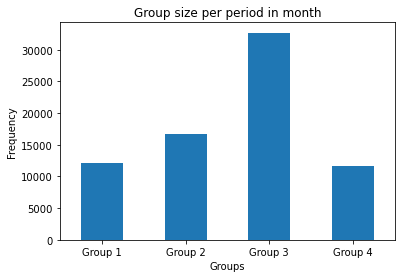

In [ ]:
#visualisation target feature of whole dataset
# newdf['Target group'].value_counts()
grp = pd.DataFrame({'Groups':['Group 1', 'Group 2', 'Group 3', 'Group 4'], 'val':[12072, 16701, 32688, 11672 ]})
ax = grp.plot.bar(x='Groups', y='val', rot=0, ylabel='Frequency', title='Group size per period in month',legend=False)

In [ ]:
# newdf.describe()

,aantal_jaar_lid,dispuut,betalinsgregeling,aantal_regels,hh_car,huishoudgrootte,leeftijd,Target group
count,73133.000000,73133.000000,73133.000000,73133.000000,73133.000000,73133.000000,73133.000000,73133.000000
mean,3.628512,0.003159,0.001668,7.681129,0.750154,2.223483,38.975770,2.601097
std,6.195900,0.056113,0.040810,6.339454,0.671894,1.256387,12.841905,0.942936
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,17.000000,1.000000
25%,1.000000,0.000000,0.000000,5.000000,0.000000,1.000000,29.000000,2.000000
50%,2.000000,0.000000,0.000000,6.000000,1.000000,2.000000,37.000000,3.000000
75%,2.000000,0.000000,0.000000,8.000000,1.000000,3.000000,48.000000,3.000000
max,64.000000,1.000000,1.000000,192.000000,2.000000,5.000000,106.000000,4.000000


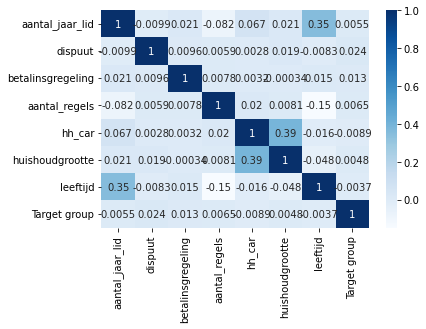

In [ ]:
# corrMatrix = newdf.corr()
# sns.heatmap(corrMatrix, annot=True, cmap='Blues')
# plt.show()

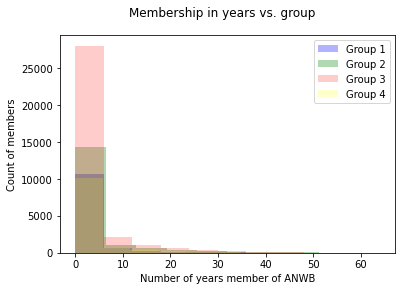

In [ ]:
# fig, ax = plt.subplots()

# ax.hist(newdf[newdf["Target group"]== 1]["aantal_jaar_lid"], bins=10, alpha=0.3, color="blue", label="Group 1")
# ax.hist(newdf[newdf["Target group"]== 2]["aantal_jaar_lid"], bins=10, alpha=0.3, color="green", label="Group 2")
# ax.hist(newdf[newdf["Target group"]==3]["aantal_jaar_lid"], bins=10, alpha=0.2, color="red", label="Group 3")
# ax.hist(newdf[newdf["Target group"]==4]["aantal_jaar_lid"], bins=10, alpha=0.2, color="yellow", label="Group 4")

# ax.set_xlabel("Number of years member of ANWB")
# ax.set_ylabel("Count of members")

# fig.suptitle("Membership in years vs. group")

# ax.legend()

Text(0.5, 1.0, 'Payment period per customer segment')

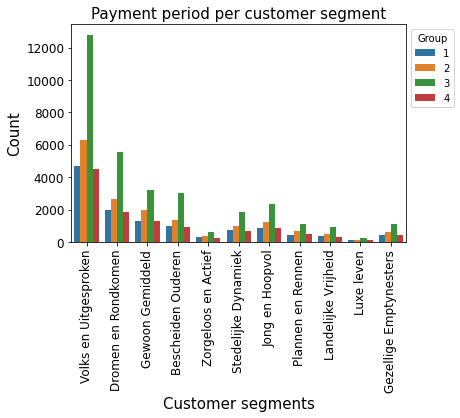

In [ ]:
# p = sns.countplot(data=newdf, x='whize_segment', hue='Target group')#.set(title='Payment period per customer segment')
# p.legend(title='Group', bbox_to_anchor=(1, 1), loc='upper left',fontsize = 10)
# plt.xticks(rotation=90, fontsize = 12)
# plt.yticks( fontsize = 12)
# p.set_xlabel("Customer segments", fontsize = 15)
# p.set_ylabel("Count", fontsize = 15)
# p.set_title("Payment period per customer segment", fontsize = 15)

Text(0.5, 1.0, 'Income')

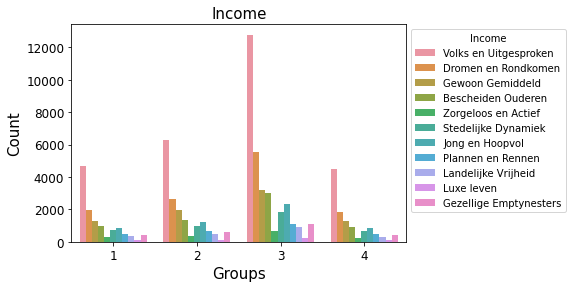

In [ ]:
# p = sns.countplot(data=newdf, x='Target group', hue='whize_segment')#.set(title='Payment period per customer segment')
# p.legend(title='Income', bbox_to_anchor=(1, 1), loc='upper left',fontsize = 10)
# plt.xticks( fontsize = 12)
# plt.yticks( fontsize = 12)
# p.set_xlabel('Groups' ,fontsize = 15)
# p.set_ylabel("Count", fontsize = 15)
# p.set_title("Income", fontsize = 15)

Text(0.5, 1.0, 'Payment period per income category')

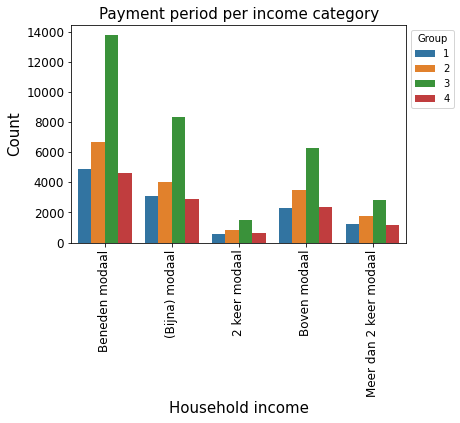

In [ ]:
# p = sns.countplot(data=newdf, x='gezinsinkomen', hue='Target group')#.set(title='Payment period per customer segment')
# p.legend(title='Group', bbox_to_anchor=(1, 1), loc='upper left',fontsize = 10)
# plt.xticks(rotation=90, fontsize = 12)
# plt.yticks( fontsize = 12)
# p.set_xlabel("Household income", fontsize = 15)
# p.set_ylabel("Count", fontsize = 15)
# p.set_title("Payment period per income category", fontsize = 15)

Text(0.5, 1.0, 'Income')

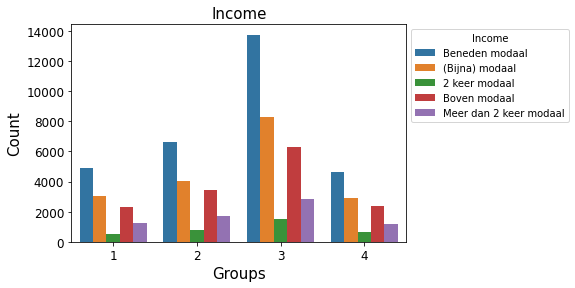

In [ ]:
# p = sns.countplot(data=newdf, x='Target group', hue='gezinsinkomen')#.set(title='Payment period per customer segment')
# p.legend(title='Income', bbox_to_anchor=(1, 1), loc='upper left',fontsize = 10)
# plt.xticks( fontsize = 12)
# plt.yticks( fontsize = 12)
# p.set_xlabel('Groups' ,fontsize = 15)
# p.set_ylabel("Count", fontsize = 15)
# p.set_title("Income", fontsize = 15)

Text(0.5, 1.0, 'Payment period based on number of cars')

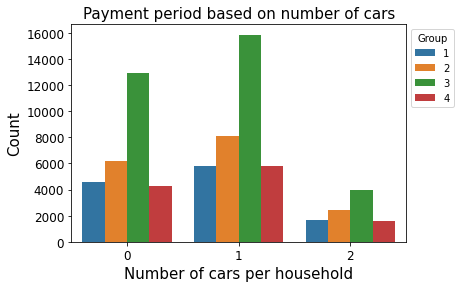

In [ ]:
# p = sns.countplot(data=newdf, x='hh_car', hue='Target group')#.set(title='Payment period per customer segment')
# p.legend(title='Group', bbox_to_anchor=(1, 1), loc='upper left',fontsize = 10)
# plt.xticks( fontsize = 12)
# plt.yticks( fontsize = 12)
# p.set_xlabel("Number of cars per household", fontsize = 15)
# p.set_ylabel("Count", fontsize = 15)
# p.set_title("Payment period based on number of cars", fontsize = 15)

Text(0.5, 1.0, 'Payment period based on number of cars')

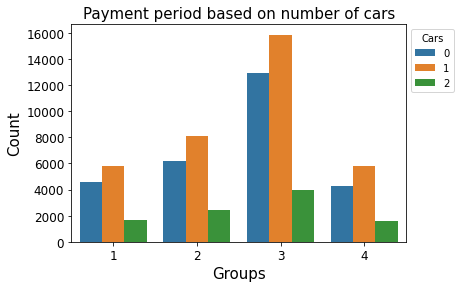

In [ ]:
# p = sns.countplot(data=newdf, x='Target group', hue='hh_car')#.set(title='Payment period per customer segment')
# p.legend(title='Cars', bbox_to_anchor=(1, 1), loc='upper left',fontsize = 10)
# plt.xticks( fontsize = 12)
# plt.yticks( fontsize = 12)
# p.set_xlabel("Groups", fontsize = 15)
# p.set_ylabel("Count", fontsize = 15)
# p.set_title("Payment period based on number of cars", fontsize = 15)

Text(0.5, 1.0, 'Payment period based on worksituation')

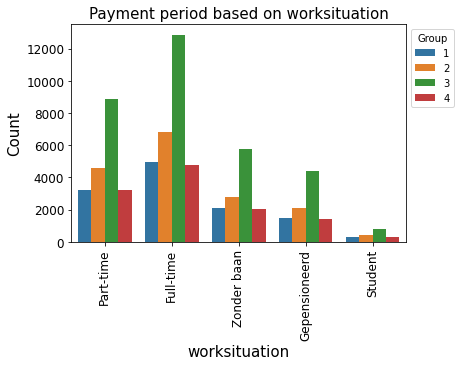

In [ ]:
# p = sns.countplot(data=newdf, x='werksituatie', hue='Target group')#.set(title='Payment period per customer segment')
# p.legend(title='Group', bbox_to_anchor=(1, 1), loc='upper left',fontsize = 10)
# plt.xticks(rotation=90, fontsize = 12)
# plt.yticks( fontsize = 12)
# p.set_xlabel("worksituation", fontsize = 15)
# p.set_ylabel("Count", fontsize = 15)
# p.set_title("Payment period based on worksituation", fontsize = 15)

Text(0.5, 1.0, 'Payment period based on worksituation')

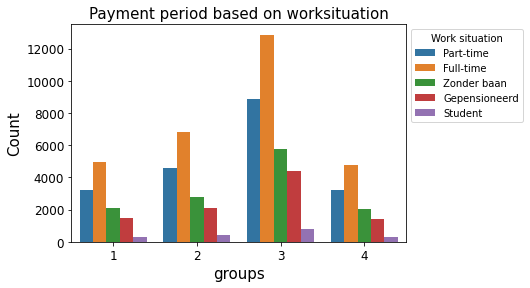

In [ ]:
p = sns.countplot(data=newdf, x='Target group', hue='werksituatie')#.set(title='Payment period per customer segment')
p.legend(title='Work situation', bbox_to_anchor=(1, 1), loc='upper left',fontsize = 10)
plt.xticks( fontsize = 12)
plt.yticks( fontsize = 12)
p.set_xlabel("groups", fontsize = 15)
p.set_ylabel("Count", fontsize = 15)
p.set_title("Payment period based on worksituation", fontsize = 15)

In [ ]:
# newdf['storno_reden'].value_counts(normalize=True)

In [ ]:
newdf.storno_reden .value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

(AM04) Geen saldo                                                57.79%
(MD06) Geïncasseerde heeft verzocht het geld terug te storten    24.78%
(SL01) Administratieve reden                                      4.59%
(AC06) Euro incasso blokkade                                      4.58%
(MS02) Geweigerd door debiteur                                    2.63%
(MS03) Geweigerd door bank                                        2.23%
(AC04) Rekeningnummer gesloten                                    1.98%
(AG01) Administratieve reden                                      1.05%
(AC01) Onjuist rekeningnummer                                     0.26%
(MD01) Geen machtiging                                            0.07%
(DNOR) Bic niet aangesloten                                       0.04%
(RR01) Onjuiste incasso                                           0.01%
(FF01) Fout bestandsformaat                                        0.0%
Name: storno_reden, dtype: object

### Creating dummies

In [ ]:
# factuurbedrag needs to become a numeric value 
fact =[]
for i in newdf['factuurbedrag'].astype(str):
    fact.append(i.replace(',', '.'))
    
newdf['factuurbedrag']= fact
newdf['factuurbedrag'] = newdf['factuurbedrag'].astype(float)

In [ ]:
# check types to see what you need to make numerical
newdf.info()

In [ ]:
# dummies for storno_reden dispuut betalinsgregeling ontvangstmethode bulk_vordering invoice_currency_code type_vordering verzendwijze product_type  

storno = pd.get_dummies(newdf.storno_reden, prefix='storno_reden')
product = pd.get_dummies(newdf.producten, prefix='producten').iloc[:,1:]
whseg = pd.get_dummies(newdf.whize_segment, prefix='whize_segment').iloc[:,1:]
hwsub= pd.get_dummies(newdf.whize_subsegment, prefix='whize_subsegment').iloc[:,1:]
inkomen = pd.get_dummies(newdf.gezinsinkomen, prefix='gezinsinkomen').iloc[:,1:]
werk= pd.get_dummies(newdf.werksituatie, prefix='werksituatie').iloc[:,1:]
huis= pd.get_dummies(newdf.huishoudgrootte, prefix='huishoudgrootte').iloc[:,1:]


In [ ]:
dummies = pd.concat([newdf, storno], axis=1)
dummies = pd.concat([dummies, product], axis=1)
dummies = pd.concat([dummies, whseg], axis=1)
dummies = pd.concat([dummies, hwsub], axis=1)
dummies = pd.concat([dummies, werk], axis=1)
dummies = pd.concat([dummies, inkomen], axis=1)
dummies = pd.concat([dummies, huis], axis=1)

dummies.drop(['storno_reden', 'producten', 'whize_segment', 'whize_subsegment', 'gezinsinkomen', 'werksituatie',  'huishoudgrootte' ], axis=1, inplace=True)

In [ ]:
dummies.dtypes

In [ ]:
# save the dataframe to a csv file to start in a new notebook 
# dummies.to_csv('clean code.csv') 

### Splitting data into train and test set

In [ ]:
y = dummies['Target group'] 
X = dummies.drop(columns=['Target group'])

X['aantal_jaar_lid']=X['aantal_jaar_lid'].astype(np.int32)
X['leeftijd']=X['leeftijd'].astype(np.int32)
X['dispuut']=X['dispuut'].astype(np.int32)
X['betalinsgregeling']=X['betalinsgregeling'].astype(np.int32)
X['aantal_regels']=X['aantal_regels'].astype(np.int32)
X['hh_car']=X['hh_car'].astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=123)

### Logistic regression baseline 

In [ ]:
lr= LogisticRegression()
lr.fit(X_train, y_train) #training the model

y_pred = lr.predict(X_test)  #predicting on the validation set
# lr.score(X_val, y_val, scoring ='f1_weighted')

# calculting the baseline 
print ('The f1 score is:',f1_score(y_test, y_pred, average='weighted'))
print ('The accuracy score is:' , accuracy_score(y_test, y_pred ))

# f1 score = Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). 
# This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

The f1 score is: 0.2798250453279621
The accuracy score is: 0.4475285431052164


 ### Random forest baseline

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train) #training the model

y_pred = rf.predict(X_test)  #predicting on the test set

# evaluating & printing the scores
print ('The f1 score is:',f1_score(y_test, y_pred, average='weighted'))
print ('The accuracy score is:' , accuracy_score(y_test, y_pred ))

The f1 score is: 0.4747713343774907
The accuracy score is: 0.4914883434743967
